In [158]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
import csv
%matplotlib inline

In [44]:
#loading data
data_dicts = pickle.load(open('pe_data_dicts', 'r'))

In [144]:
all_hists = {}
#plotting and returning histogram of target states per grasp
def plot_save_hist(data, nbins=10, drange=None, show=False, save_file = None, xlabel=None, ylabel=None, title=None):
    if title is None:
        raise Exception("Histogram must have a title!")
    all_hists[title] = data
    
    plt.clf()
    n, bins, patches = plt.hist(data, bins=nbins, range=drange, alpha=0.75)
    
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
    
    if save_file is not None:
        plt.savefig(save_file)
    if show:
        plt.show()

In [48]:
def ensure_dir_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [52]:
#plotting and saving distributions of target states per object per grasp
def gen_hist_target_states(obj_name, grasps, desired_states, root_dir):
    for grasp_id in grasps:
        for state in desired_states:
            data = grasps[grasp_id]['target_states'][state]
            
            title = 'Target_State_Obj_{0}_Grasp_{1}_State_{2}'.format(obj_name, grasp_id, state)
            dest_dir = os.path.join(root_dir, obj_name, str(grasp_id))
            fig_file = os.path.join(dest_dir, title+'.png')

            ensure_dir_exists(dest_dir)
            plot_save_hist(data, 5, save_file=fig_file, xlabel=state, title=title)

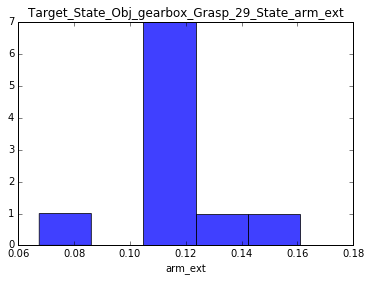

In [53]:
desired_target_states = ['arm_elev', 'arm_rot', 'arm_ext']
#generating all target states graphs:
for obj_name in data_dicts:
    gen_hist_target_states(obj_name, data_dicts[obj_name]['grasps'], desired_target_states, 'graphs')

In [145]:
#plotting and saving diffs between target and actual states for all trials
def gen_hist_diff_states(data, desired_states, root_dir, params):
    diffs = {state:[] for state in desired_states}
    
    for obj_name in data:
        for grasp_id, grasp in data[obj_name]['grasps'].items():
            for state in desired_states:
                target_vals = grasp['target_states'][state]
                actual_vals = grasp['actual_states'][state]
                diff = [actual_vals[i] - target_vals[i] for i in range(len(actual_vals))]
                diffs[state].extend(diff)

    for state, diff in diffs.items():
        title = 'Diff_of_Actual_and_Target_States_{0}'.format(state)
        dest_dir = os.path.join(root_dir, 'diffs')
        fig_file = os.path.join(dest_dir, title+'.png')

        ensure_dir_exists(dest_dir)
        plot_save_hist(diff, params[state][0], params[state][1], save_file=fig_file, xlabel=state, title=title)

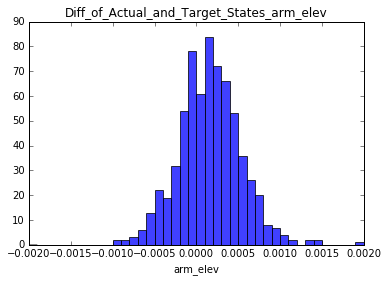

In [146]:
params = {
    'arm_elev': [40, [-0.002, 0.002]],
    'arm_rot': [20, None],
    'arm_ext': [40, [-0.005, 0.005]],
    'gripper_rot': [40, [-0.05, 0.05]],
    'gripper_grip': [30, None]
}
desired_diff_states = ['arm_elev', 'arm_rot', 'arm_ext', 'gripper_rot', 'gripper_grip']
gen_hist_diff_states(data_dicts, desired_diff_states, 'graphs', params)

In [147]:
#plotting and saving hist of time took for each object
def gen_hist_dur(data, root_dir):
    
    for obj_name in data:
        durs = []
        for grasp_id, grasp in data[obj_name]['grasps'].items():
            durs.extend(grasp['grasp_output']['duration'])            
        
        title = 'Duration_of_Trials_{0}'.format(obj_name)
        dest_dir = os.path.join(root_dir, 'durs')
        fig_file = os.path.join(dest_dir, title+'.png')

        ensure_dir_exists(dest_dir)
        plot_save_hist(durs, 20, save_file=fig_file, xlabel='seconds', title=title)

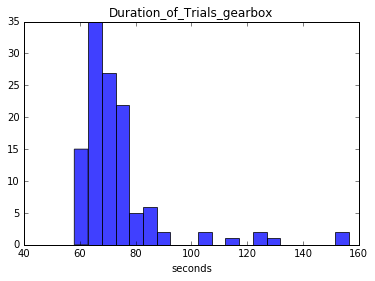

In [148]:
gen_hist_dur(data_dicts, 'graphs')

In [149]:
#exploring correlation between grasp width differences and success
all_succeses = []
all_grasp_width_diffs = []
for obj_name in data_dicts:
    for grasp_id, grasp in data_dicts[obj_name]['grasps'].items():
        successes = grasp['grasp_output']['success']
        actuals = grasp['actual_states']['gripper_grip']
        targets = grasp['target_states']['gripper_grip']
        diffs = [actuals[i] - targets[i] + 0.068 for i in range(len(actuals))]
        
        all_succeses.extend(successes)
        all_grasp_width_diffs.extend(diffs)
all_succeses = np.array(all_succeses)
all_grasp_width_diffs = np.array(all_grasp_width_diffs)

In [150]:
width_diffs_failures = np.take(all_grasp_width_diffs, np.argwhere(all_succeses == 0))
width_diffs_successes = np.take(all_grasp_width_diffs, np.argwhere(all_succeses == 1))

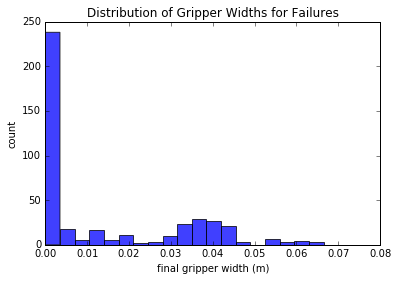

In [151]:
plot_save_hist(width_diffs_failures, 20, [0, 0.07], show=True, 
               title='Distribution of Gripper Widths for Failures', xlabel='final gripper width (m)', ylabel='count')

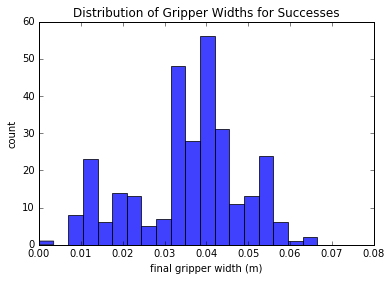

In [152]:
plot_save_hist(width_diffs_successes, 20, [0, 0.07], show=True, 
               title='Distribution of Gripper Widths for Successes', xlabel='final gripper width (m)', ylabel='count')

In [155]:
#saving all corresponding stats of interests for all hists
def gen_stats(name, data, flags):
    ops = (np.mean, np.median, np.std)
    result = [name]
    
    for flag, val in flags.items():
        if not val:
            result.extend([np.nan]*len(ops))
        else:
            if flag == 'abs':
                data = np.abs(data)
            elif flag == 'square':
                data = data**2
            result.extend([op(data) for op in ops])
    
    return result

In [166]:
flags = {
    'generic':True,
    'abs':True,
    'square':True
}
results = []

for name, data in all_hists.items():
    data = all_hists[name]
    if name.startswith('Duration'):
        flags['generic']=True
        flags['abs']=False
        flags['square']=False
    elif name.startswith('Diff'):
        flags['generic']=True
        flags['abs']=True
        flags['square']=True
    elif name.startswith('Distribution'):
        flags['generic']=True
        flags['abs']=False
        flags['square']=False
    
    results.append(gen_stats(name, data, flags))

In [170]:
header = ['name', 'mean', 'median', 'std', 'abs mean', 'abs median', 'abs std', 'sqr mean', 'sqr median', 'sqr std']
with open('pe_stats.csv', 'wb') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)
    for result in results:
        writer.writerow(result)